<a href="https://colab.research.google.com/github/shammy45/Linear-and-Logistic-regression/blob/master/Linear_Regression_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Our first tiny application

In [ ]:
import scipy
scipy.version.full_version

'1.4.1'

## Generating some toy data for our web startup

In [ ]:
# This script generates web traffic data for our hypothetical
# web startup "MLaaS"

import os
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), "data")
CHART_DIR = os.path.join(os.getcwd(), "charts")

for d in [DATA_DIR, CHART_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

np.random.seed(3)  # to reproduce the data later on

def gen_web_traffic_data():
    '''
    This function generates some fake data that first shows a weekly pattern 
    for a couple weeks before it grows exponentially.
    '''
    x = np.arange(1, 31*24)
    y = np.array(200*(np.sin(2*np.pi*x/(7*24))), dtype=np.float32)
    y += gamma.rvs(15, loc=0, scale=100, size=len(x))
    y += 2 * np.exp(x/100.0)
    y = np.ma.array(y, mask=[y<0])

    # We introduce some "real-world" data, to later demonstrate how to clean 
    # it conveniently.
    y[[2,23,48,95,154,180,181,210]] = np.nan

    return x, y

def plot_web_traffic(x, y, models=None, mx=None, ymax=None, fig_idx=None):
    '''
    Plot the web traffic (y) over time (x). 
    
    If models is given, it is expected to be a list fitted models,
    which will be plotted as well (used later in this chapter).
    '''
    plt.figure(figsize=(12,6), dpi=300) # width and height of the plot in inches
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(20)], 
               ['week %i' %w for w in range(20)])
    
    if models:
        colors = ['g', 'k', 'b', 'm', 'r']
        linestyles = ['-', '-.', '--', ':', '-']

        if mx is None:
            mx = np.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")
        
    plt.autoscale()
    if ymax:
        plt.ylim(ymax=ymax)

    plt.grid()
    plt.ylim(ymin=0)
    
    if fig_idx is not None:
        plt.savefig(os.path.join(CHART_DIR, "B09124_01_%s.png" % fig_idx))

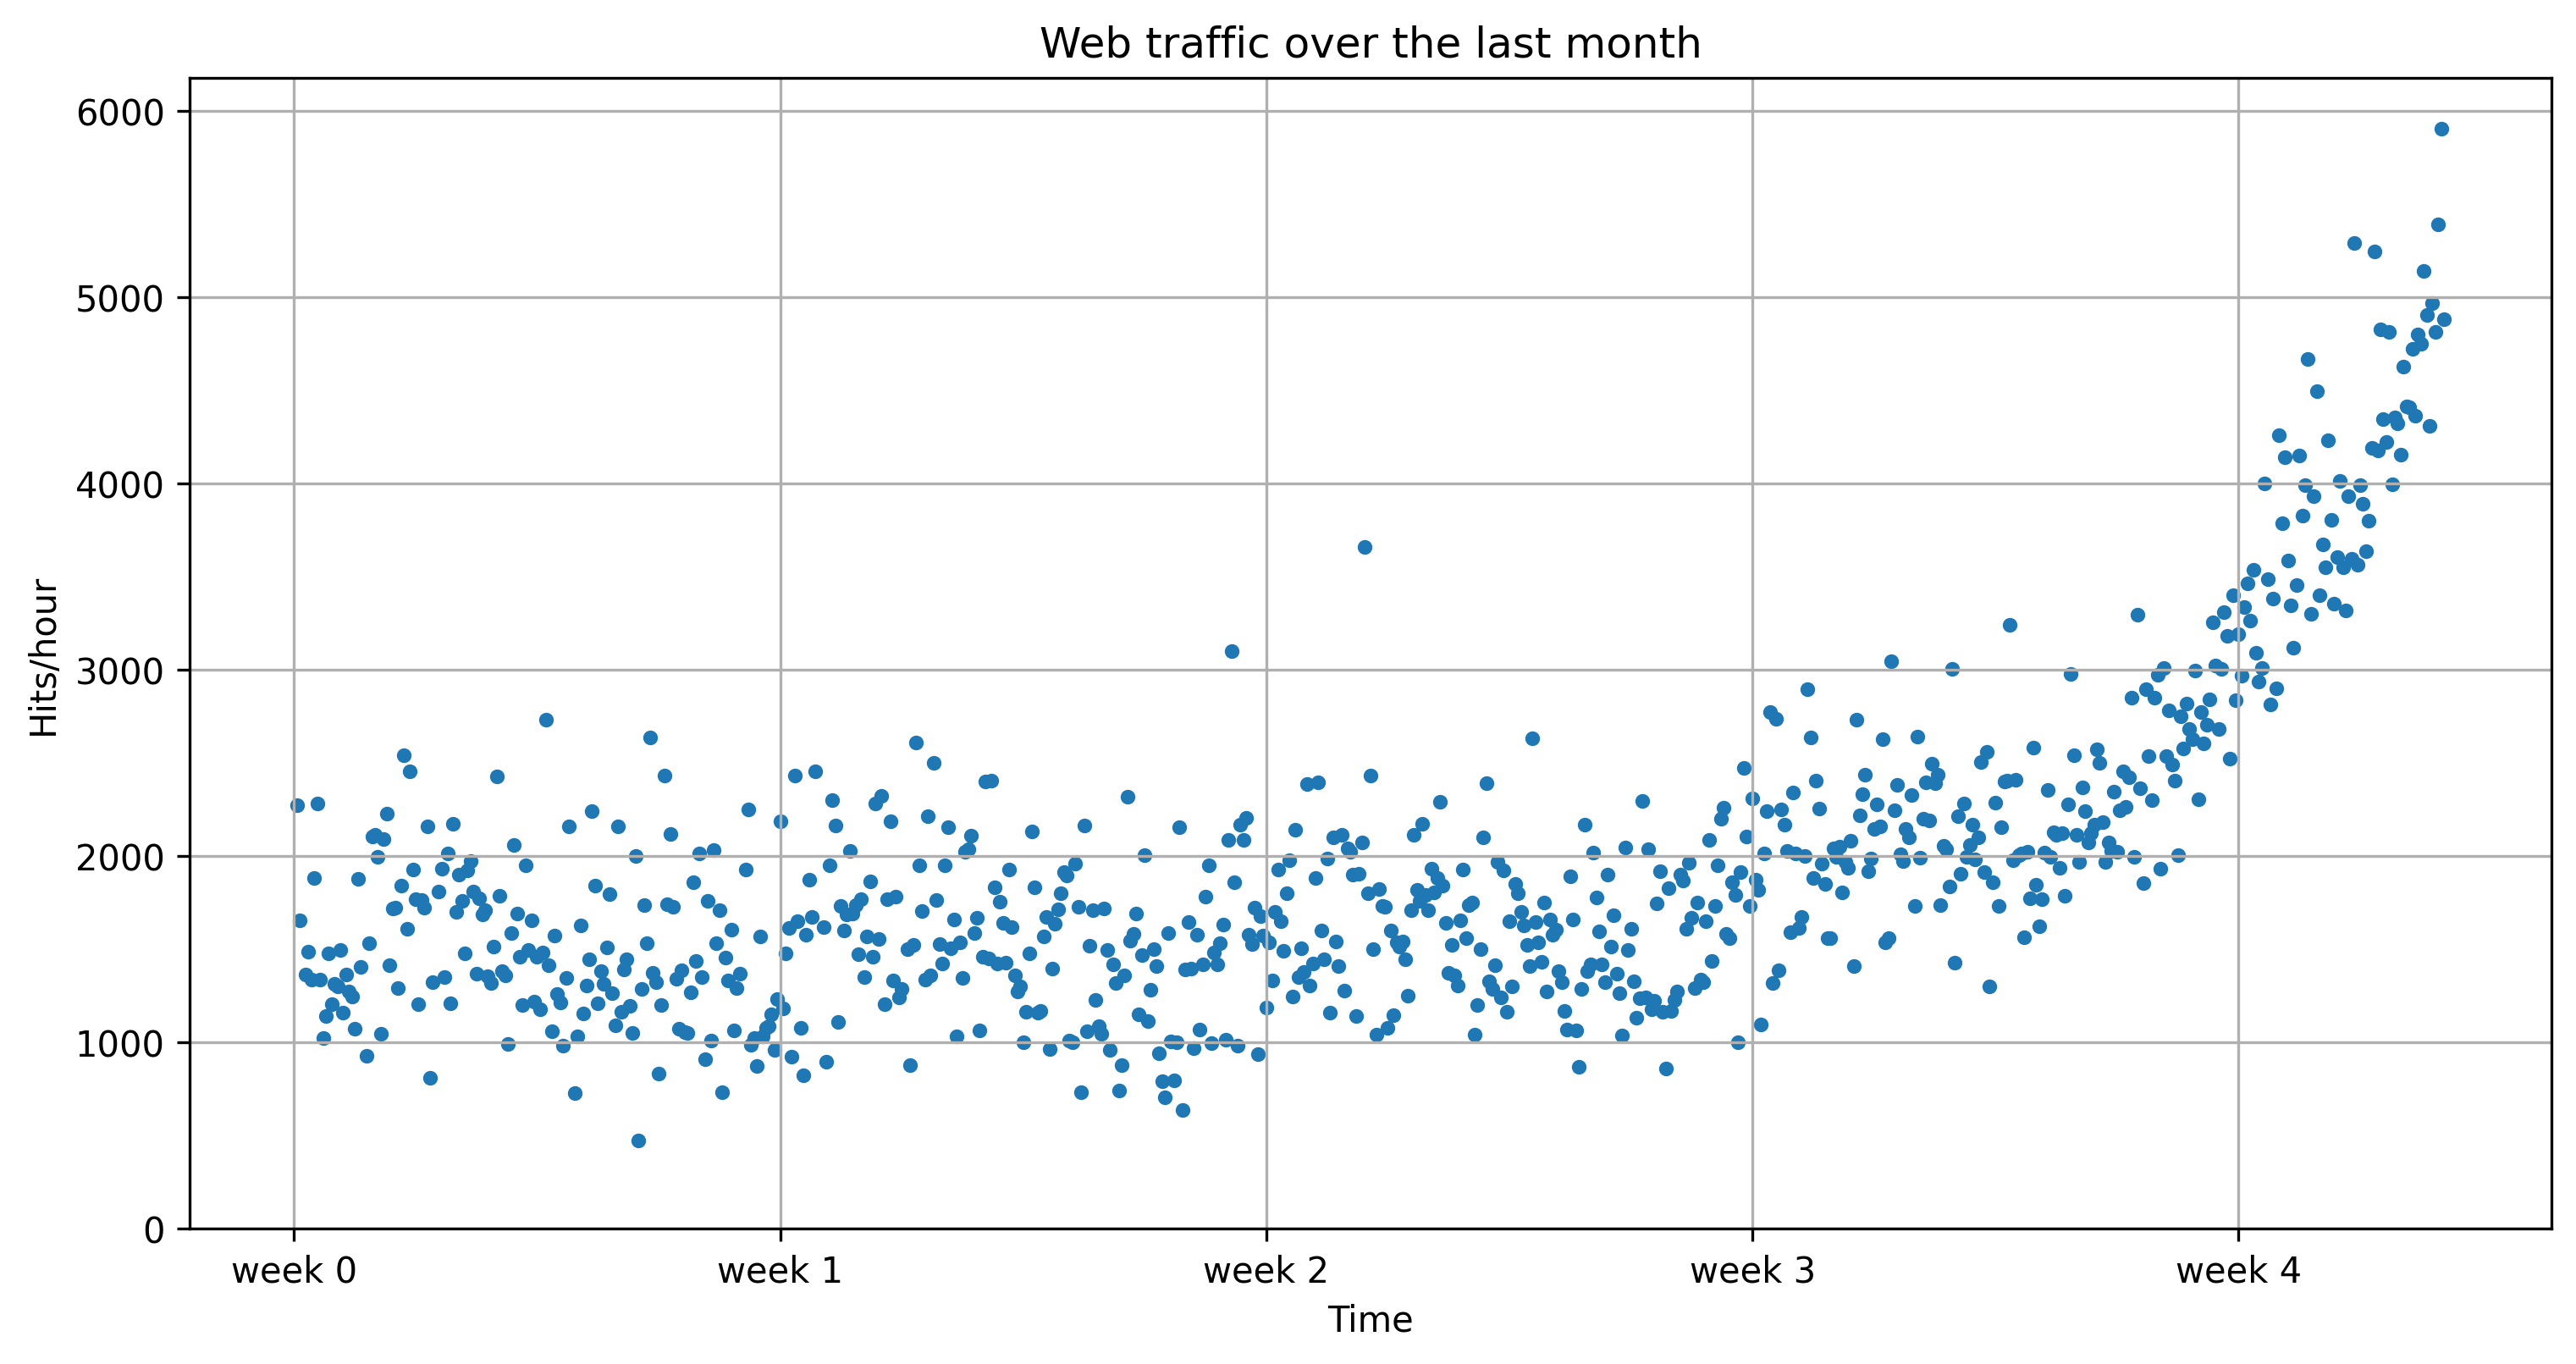

In [ ]:
x, y = gen_web_traffic_data()
np.savetxt(os.path.join(DATA_DIR, "web_traffic.tsv"), 
           list(zip(x, y)), delimiter="\t", fmt="%f")
    
plot_web_traffic(x, y, fig_idx="01")

## Reading in the data and cleaning it

In [ ]:
data = np.genfromtxt(os.path.join(DATA_DIR, "web_traffic.tsv"), delimiter="\t")

In [ ]:
print(data[:10])

[[1.00000000e+00 2.27333106e+03]
 [2.00000000e+00 1.65725549e+03]
 [3.00000000e+00            nan]
 [4.00000000e+00 1.36684644e+03]
 [5.00000000e+00 1.48923438e+03]
 [6.00000000e+00 1.33802002e+03]
 [7.00000000e+00 1.88464734e+03]
 [8.00000000e+00 2.28475415e+03]
 [9.00000000e+00 1.33581091e+03]
 [1.00000000e+01 1.02583240e+03]]


In [ ]:
print(data.shape)

(743, 2)


In [ ]:
np.sum(np.isnan(x))

0

In [ ]:
np.sum(np.isnan(y)) # this is the dirt that we introduced above

8

So we have to remove all data from `x` and `y` where `y` is `NaN`.

In [ ]:
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

## Building our first model
We will be using scipy's polynomial fitting functions in this section.

In [ ]:
fp1 = np.polyfit(x, y, 1)

In [ ]:
print("Model parameters: %s" % fp1)

Model parameters: [  2.58462016 996.50674246]


We use squared distance as the error.

In [ ]:
def error(f, x, y):
    return np.sum((f(x)-y)**2)

In [ ]:
f1 = np.poly1d(fp1)
print(error(f1, x, y))

319531507.00812596


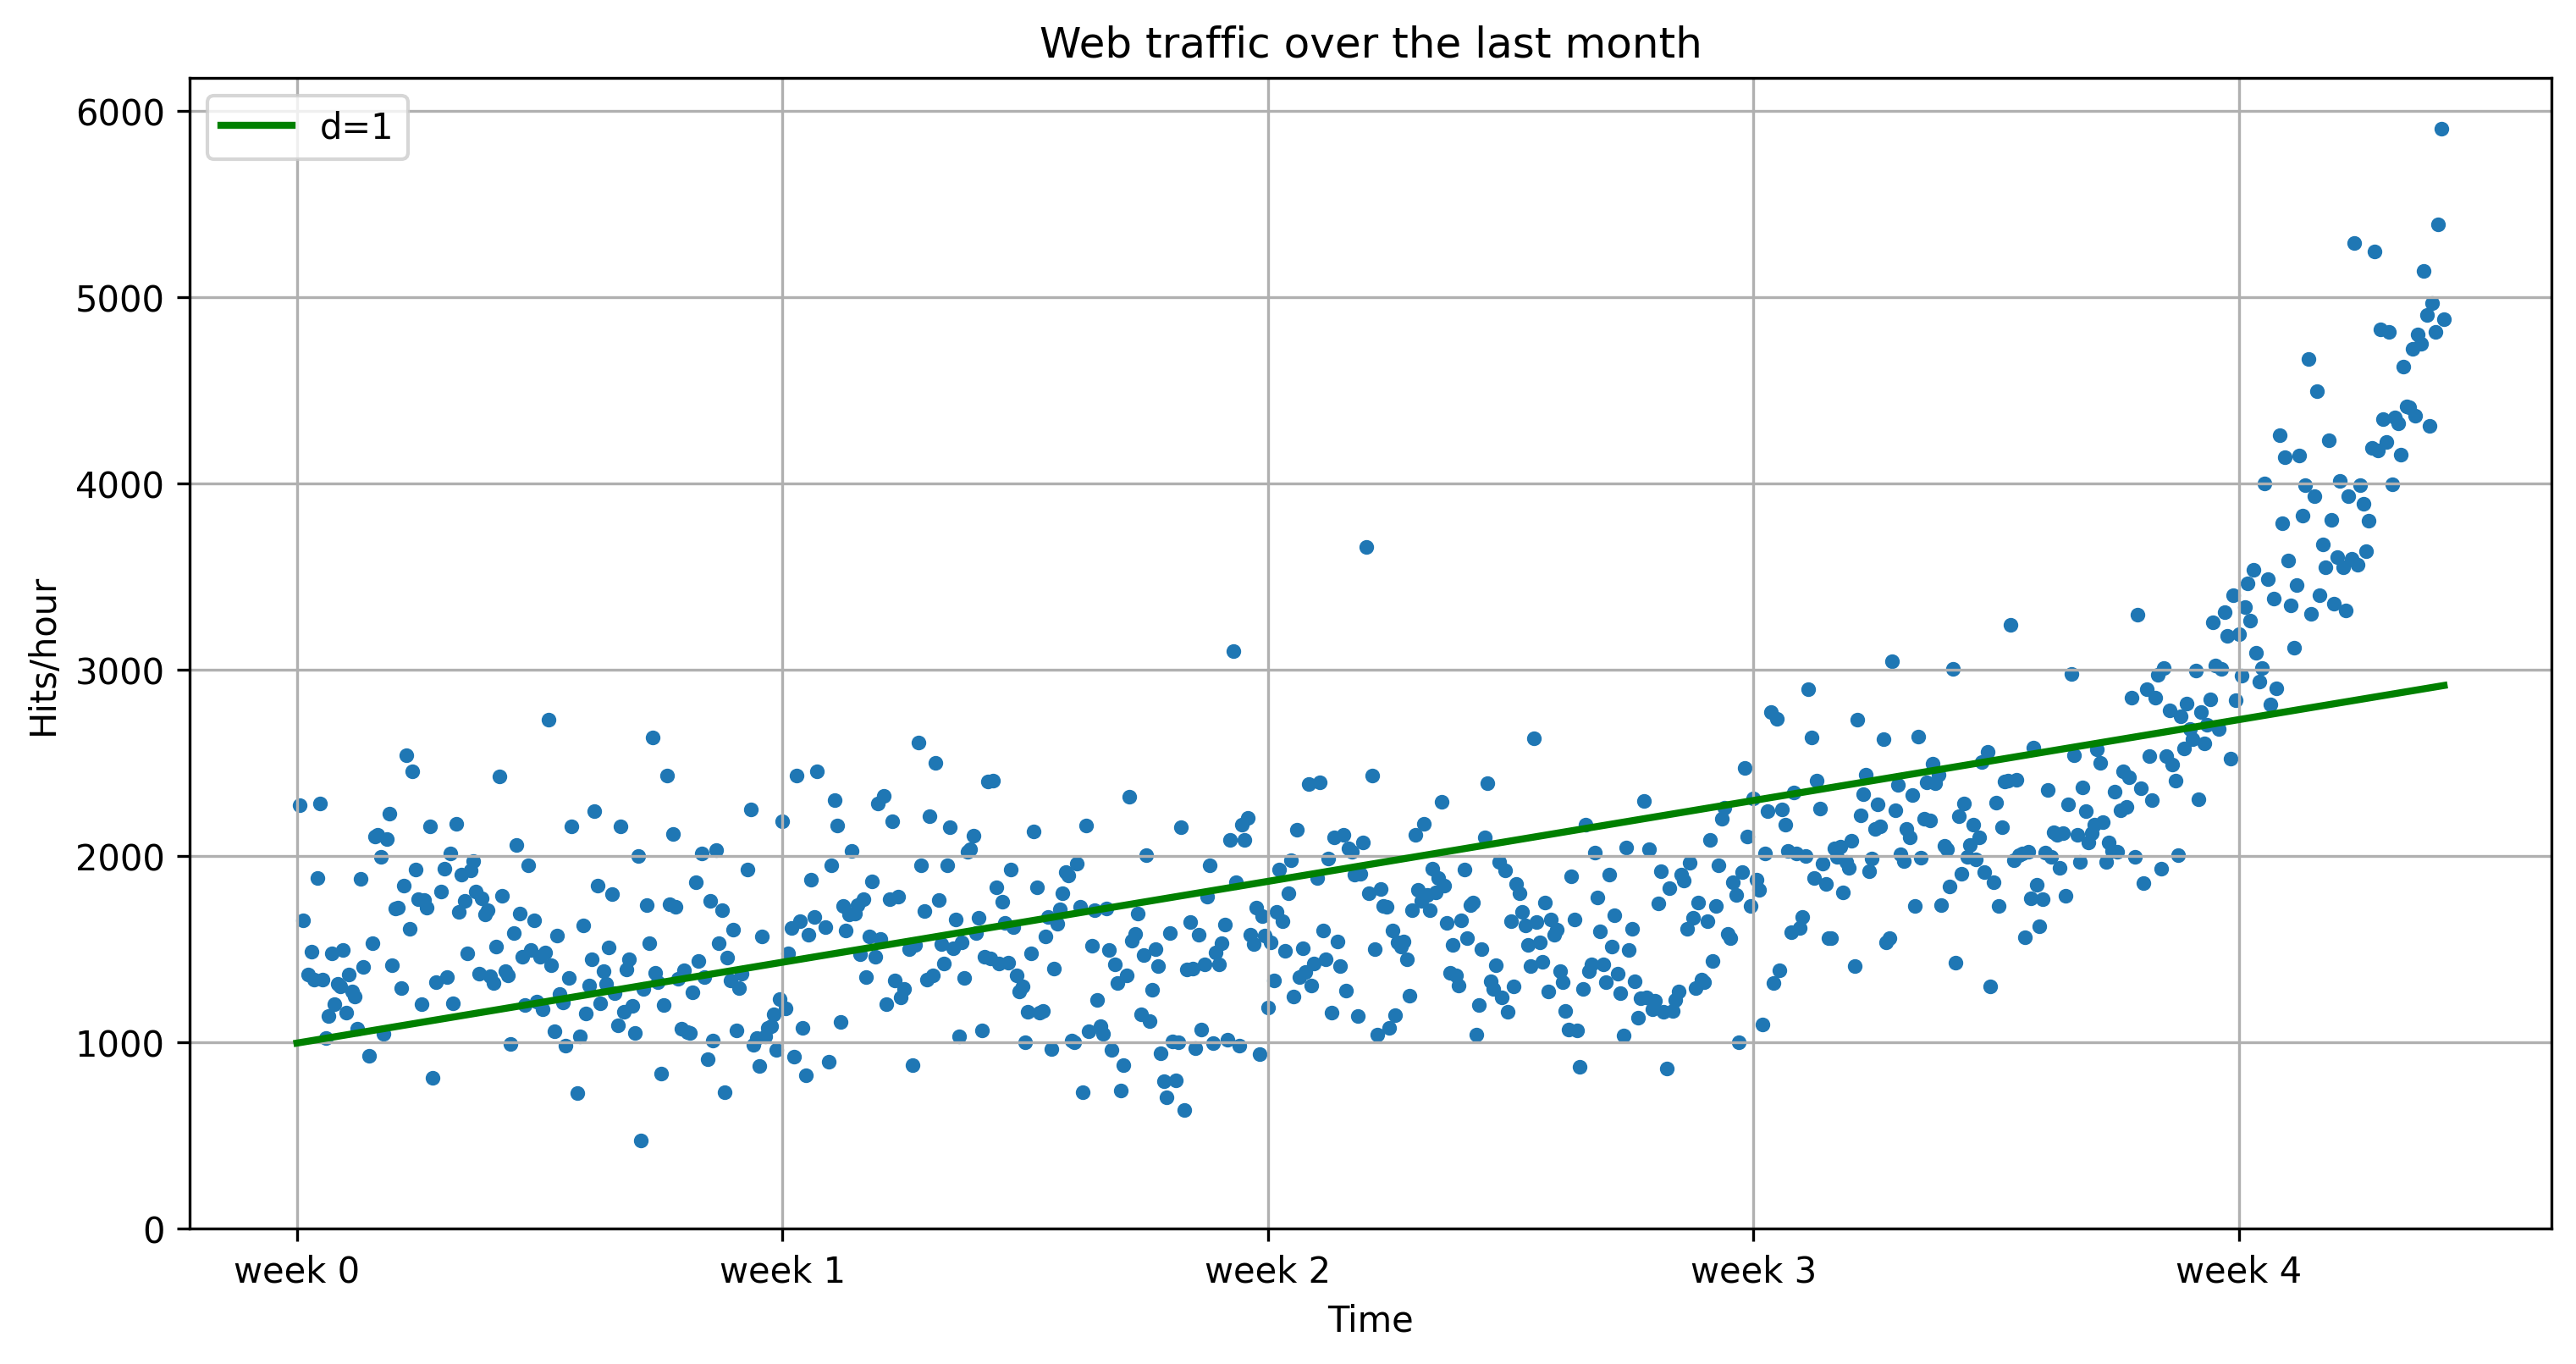

In [ ]:
plot_web_traffic(x, y, [f1], fig_idx="02")

Clearly, our web traffic cannot be modeled with only one dimension. What about two?

In [ ]:
f2p = np.polyfit(x, y, 2)

In [ ]:
print(f2p)

[ 1.05605675e-02 -5.29774287e+00  1.98466917e+03]


In [ ]:
f2 = np.poly1d(f2p)

In [ ]:
print(error(f2, x, y))

181347660.76423597


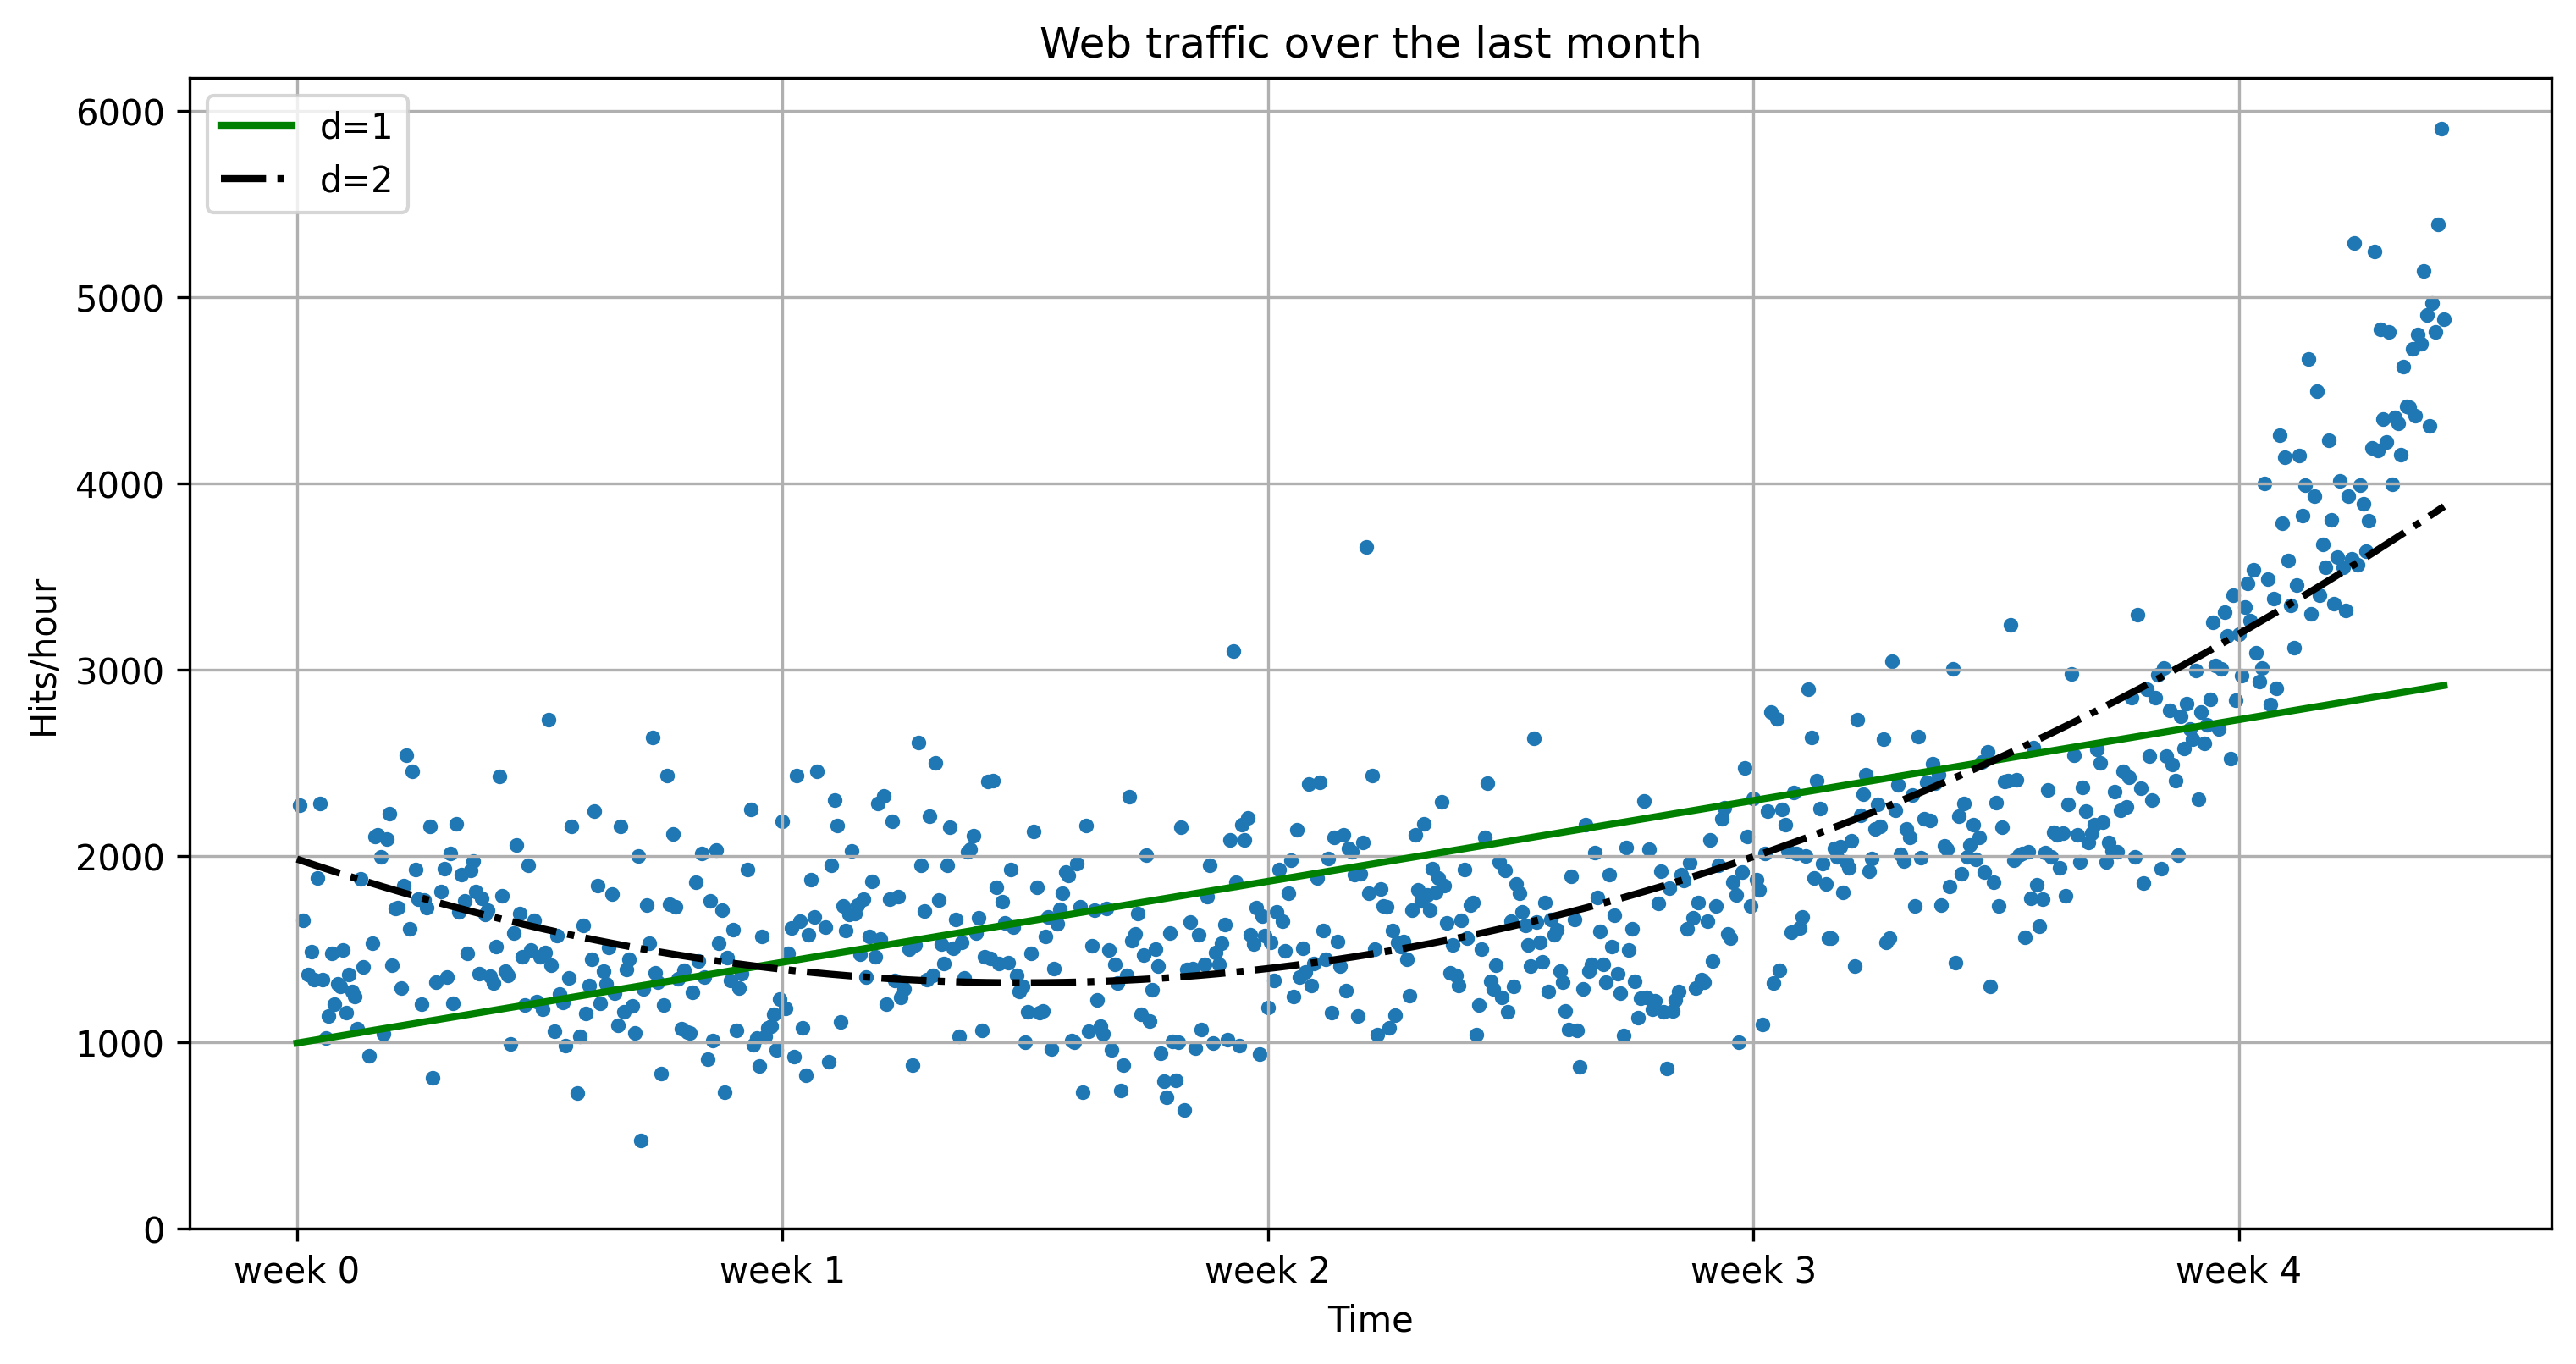

In [ ]:
plot_web_traffic(x, y, [f1, f2], fig_idx="03")

In [ ]:
f3 = np.poly1d(np.polyfit(x, y, 3))
f10 = np.poly1d(np.polyfit(x, y, 10))
f100 = np.poly1d(np.polyfit(x, y, 100))

/usr/local/lib/python3.6/dist-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


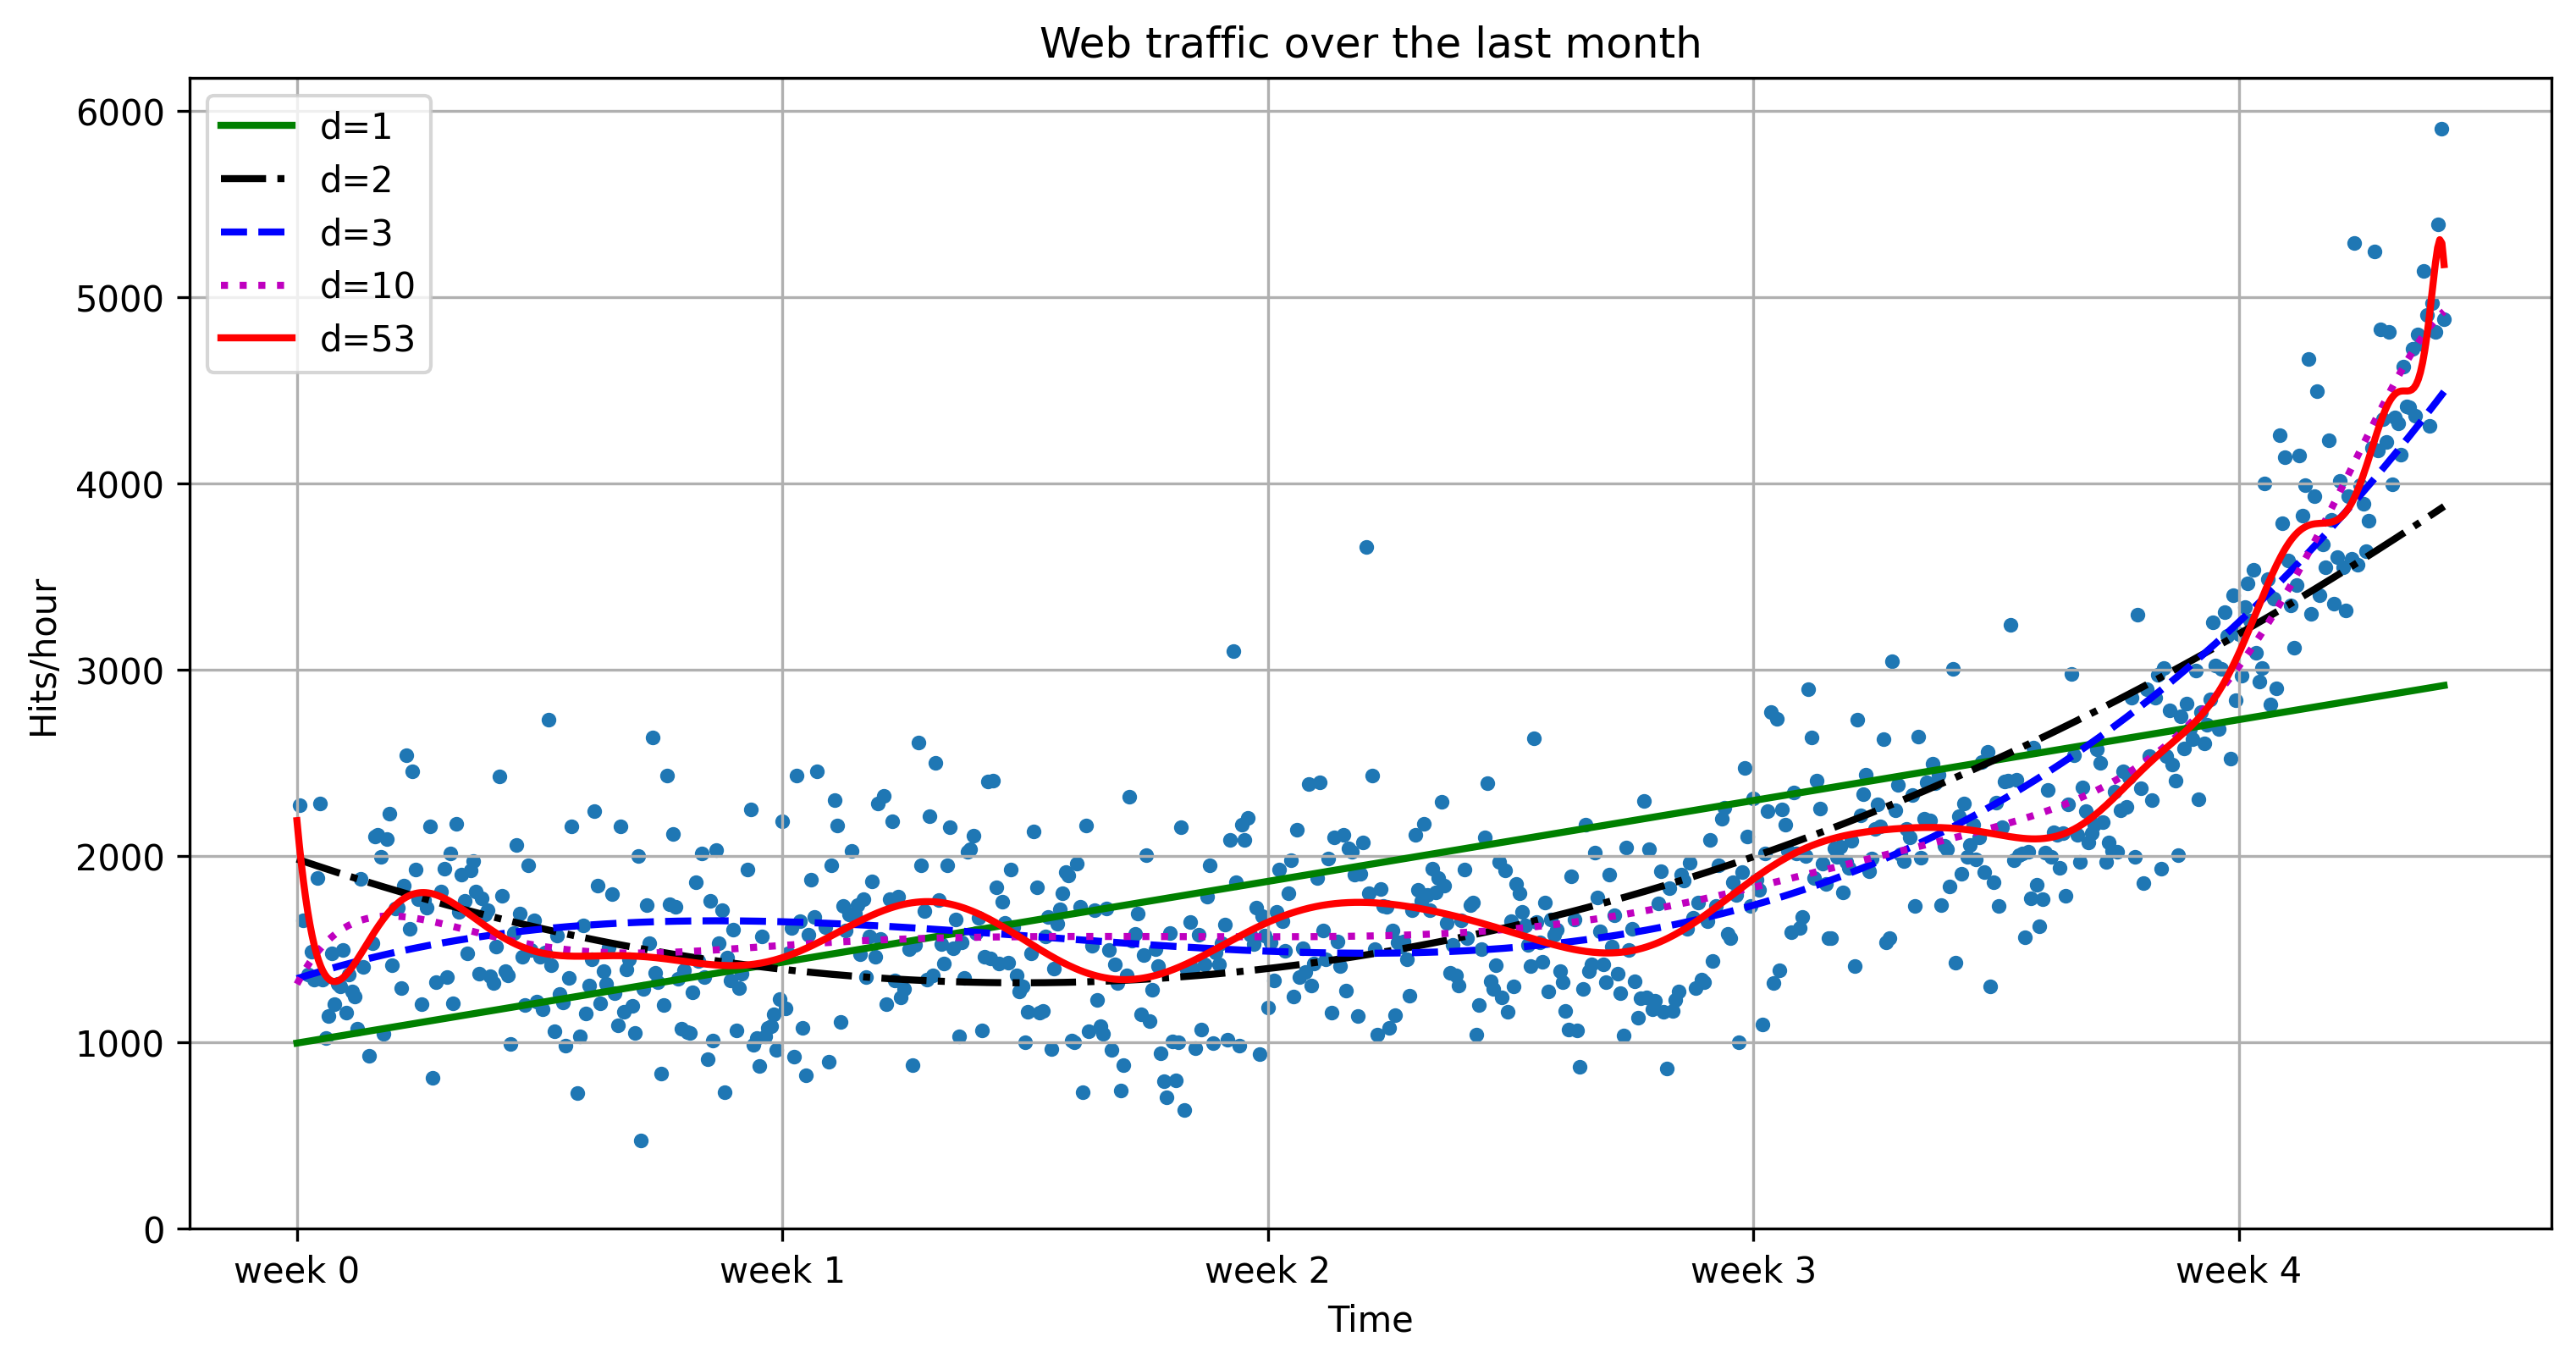

In [ ]:
plot_web_traffic(x, y, [f1, f2, f3, f10, f100], fig_idx="04")

Ok, 100 was a bit overkill. 

In [ ]:
print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("\td=%i: %f" % (f.order, error(f, x, y)))

Errors for the complete data set:
	d=1: 319531507.008126
	d=2: 181347660.764236
	d=3: 140576460.879141
	d=10: 123426935.754236
	d=53: 110768267.365618


But maybe we just haven't found the right dimension, so let's play a bit.

**Note**: if you don't see an interactive slider below the following code block, you need to enable the interactive widgets by running

```jupyter nbextension enable --py widgetsnbextension```

in the console and restart `jupyter notebook`.

In [ ]:
from ipywidgets import interactive
import ipywidgets as widgets

def play_with_dim(dim=1):
    f = np.poly1d(np.polyfit(x, y, dim))
    plot_web_traffic(x, y, [f])
    print("Error for d=%i: %f" % (f.order, error(f, x, y)))
    
interactive_plot = interactive(play_with_dim, dim=(1,100))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=1, description='dim', min=1), Output(layout=Layout(height='500px'))), _d…

## Stepping back to go forward...
It seems like there is some change between week 3 and 4. What if we treat the time before and after differently?

In [ ]:
inflection = int(3.5*7*24) # calculate the inflection point in hours
xa = x[:inflection] # data before the inflection point
ya = y[:inflection]
xb = x[inflection:] # data after
yb = y[inflection:]

fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection=%f" % (fa_error + fb_error))

Error inflection=134390576.310656


In [ ]:
fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))

plot_web_traffic(x, y, [fa, fb], fig_idx="05")

How perform our higher-degree models with our "inflection" version?

In [ ]:
plot_web_traffic(x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="06")

Ok, higher degree models don't give hope for a bright future. 
What if we had trained them onlz on the last week?

In [ ]:
fb1 = np.poly1d(np.polyfit(xb, yb, 1))
fb2 = np.poly1d(np.polyfit(xb, yb, 2))
fb3 = np.poly1d(np.polyfit(xb, yb, 3))
fb10 = np.poly1d(np.polyfit(xb, yb, 10))
fb100 = np.poly1d(np.polyfit(xb, yb, 100))

print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("\td=%i: %f" % (f.order, error(f, xb, yb)))

plot_web_traffic(
    x, y, [fb1, fb2, fb3, fb10, fb100],    
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="07")

## Splitting training and testing
Let's use 30% of the web traffic data after the inflection point as test data that we do not train on.

In [ ]:
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = np.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])
fbt1 = np.poly1d(np.polyfit(xb[train], yb[train], 1))
fbt2 = np.poly1d(np.polyfit(xb[train], yb[train], 2))
print("fbt2(x)= \n%s" % fbt2)
print("fbt2(x)-100,000= \n%s" % (fbt2-100000))
fbt3 = np.poly1d(np.polyfit(xb[train], yb[train], 3))
fbt10 = np.poly1d(np.polyfit(xb[train], yb[train], 10))
fbt100 = np.poly1d(np.polyfit(xb[train], yb[train], 100))

print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))


In [ ]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("\td=%i: %f" % (f.order, error(f, xb, yb)))

plot_web_traffic(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],    
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="08")

In [ ]:
plot_web_traffic(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],    
    mx=np.linspace(0, 12 * 7 * 24, 100),
    ymax=100000,
    fig_idx="09")

In [ ]:
print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))

## So, when will we hit 100,000 hits per hour?

In [ ]:
fbt2 = np.poly1d(np.polyfit(xb[train], yb[train], 2))
print("fbt2(x)= \n%s" % fbt2)
print("fbt2(x)-100,000= \n%s" % (fbt2-100000))

from scipy.optimize import fsolve
reached_max = fsolve(fbt2-100000, x0=800)/(7*24)
print("100,000 hits/hour expected at week %f" % reached_max[0])